In [27]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **학습 & 테스트 프로세스 요약**
| 단계 | 학습 (Train) | 테스트 (Test) |
|------|------------|-------------|
| **1. 데이터 입력** | CSV 파일 (이미 추출된 특징값) | 동영상 |
| **2. 특징 추출** | CSV에서 불러오기 | 동영상 → 프레임 추출 → 12개 묶음 → 특징 추출 |
| **3. 데이터 변환** | `(배치, 12, 5)` 형태로 변환 | `(1, 12, 5)` 형태로 변환 |
| **4. 모델 학습/예측** | LSTM 모델 학습 | LSTM 모델을 이용해 예측 |
| **5. 결과 저장** | `.pth` 파일로 저장 | 예측값 출력 |


# 1. 학습

1. 추출된 feature 로드
2. LSTM Input 형식으로 변환
3. LSTM 학습

## 라이브러리 임포트

In [28]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import random

import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import cv2
from IPython.display import display
from PIL import Image

from dataclasses import dataclass, field
from typing import Tuple, List

import warnings
warnings.filterwarnings('ignore')

from enum import Enum

class ModelType(Enum):
  BEST = "best"
  LAST = "last"

class DataType(Enum):
  TRAIN = "train"
  VAL = "val"
  TEST = "test"

base_dir = "/content/drive/MyDrive/DMS"


## 1-2. LSTM Input 형식으로 변환

### Config 설정

In [29]:
from dataclasses import dataclass

@dataclass
class Config:
    case_name: str = "bi-lstm_attention_long_window_24" # 바꿔야하는 부분

    # 모델 구조
    lstm_num_layers: int = 3
    lstm_hidden_size: int = 512
    fc_hidden_size: int = 256
    dropout_rate: float = 0.2 # input-to-hidden (between layers)
    bidirectional: bool = True

    # 학습 설정
    batch_size: int = 32
    epochs: int = 100
    learning_rate: float = 3e-4
    optimizer: str = "adam" # or "sgd", "adamw"

    # 입력 데이터(수정한 부분)
    sequence_length: int = 24
    sliding_window_step: int = 24 # sliding window 사용 x -> seuqnce_length와 같은 값으로 설정
    features: list = field(default_factory=lambda: ["mar", "ear", "yaw", "pitch", "phone_detected"])
    labels: list = field(default_factory=lambda: ["normal", "phonecall", "text", "yawn"])

    apply_yaw_inversion: bool = False
    apply_noise_jittering: bool = False

    # 학습 제어 - 조기 종료 / 러닝레이트 스케줄러
    use_early_stopping: bool = False  # 조기 종료 사용 여부
    use_lr_scheduler: bool = False    # 학습률 스케줄러 사용 여부
    early_stopping_patience: int = 20 # early stopping 기준 epoch
    reduce_lr_factor: float = 0.5 # learning rate 감소 비율
    reduce_lr_patience: int = 7 # learning rate 감소 기준 epoch

    # 랜덤시드 설정
    random_seed: int = 24

    def __post_init__(self):
      self.results_save_path = f"{base_dir}/runs/{self.case_name}"
      self.model_save_path = f"{self.results_save_path}/weights"

      os.makedirs(self.results_save_path, exist_ok=True)
      os.makedirs(self.model_save_path, exist_ok=True)

      if self.sequence_length == 12:
        df_path = f'{base_dir}/data/splits/12frame_windows'
        self.group_col = 'groups_12'
      elif self.sequence_length == 24:
        df_path = f'{base_dir}/data/splits/24frame_windows'
        self.group_col = 'groups_24'

      self.train = pd.read_csv(os.path.join(df_path, "final_train.csv"))
      self.validation = pd.read_csv(os.path.join(df_path, "final_val.csv"))
      self.test = pd.read_csv(os.path.join(df_path, "final_test.csv"))

      # label_mapping
      self.label_encoding = {}
      self.label_decoding = {}
      for i, label in enumerate(self.labels):
          self.label_encoding[label] = i # 문자열 라벨 : 숫자 인덱스
          self.label_decoding[i] = label # 숫자 인덱스 : 문자열 라벨

      # 디바이스 설정
      self.use_cuda = torch.cuda.is_available()
      self.device = torch.device("cuda" if self.use_cuda else "cpu")

cfg = Config()
# print(cfg.case_name) # 사용 예시

In [30]:
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU 연산에 대한 시드 설정
    torch.cuda.manual_seed(seed)  # CUDA 연산에 대한 시드 설정 (GPU 사용 시)
    torch.cuda.manual_seed_all(seed)  # 여러 GPU를 사용하는 경우 모든 GPU에 동일한 시드 설정
    np.random.seed(seed)  # NumPy 연산에 대한 시드 설정
    random.seed(seed)  # Python 기본 random 모듈의 시드 설정
    torch.backends.cudnn.deterministic = True  # CuDNN 연산의 결정론적 동작 보장
    torch.backends.cudnn.benchmark = False  # 성능 최적화 비활성화 (재현성 보장)

set_random_seed(cfg.random_seed)

### 데이터 로드

### train, val, test 데이터셋 로드

In [31]:
train_df = cfg.train.copy()
val_df = cfg.validation.copy()
test_df = cfg.test.copy()

In [32]:
# train normal undersampling
train_df = train_df[((train_df['label'] == 'normal') &
                    (train_df[cfg.group_col].isin([1, 2]))) | # sequence_length에 따라 group_col이 설정됨 -> 파일 로드 -> group_col로 정의된 groups_12 열 가져오기
                    (train_df['label'] != 'normal')]

### generate_sequence_dataset

In [33]:
def generate_sequence_dataset(
    df: pd.DataFrame
) -> Tuple[np.ndarray, np.ndarray, List[Tuple]]: # 가독성을 위해 변환 타입 명시. 작동x
    sequences, labels, metadata = [], [], []

    for (label, clip_id), clip_df in df.groupby(['label', 'clip_id']):
        clip_df = clip_df.sort_values('frame_no')
        frame_values = clip_df[cfg.features].values #(프레임 수, 변수 수)

        if len(frame_values) < cfg.sequence_length:
            continue

        for i in range(0, len(frame_values) - cfg.sequence_length + 1, cfg.sliding_window_step): # 전체 120, 슬라이딩 윈도우 12라면 (0, 109, 12)로 잘 들어간다
            seq = frame_values[i:i + cfg.sequence_length]
            if seq.shape[0] == cfg.sequence_length:
                sequences.append(seq)
                labels.append(cfg.label_encoding[label])
                # 학습 후 오분류 데이터 확인을 위한 시작 프레임 번호 저장
                metadata.append((label, clip_id, clip_df.iloc[i]['frame_no']))

    return TensorDataset(torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)), metadata

### DataLoader

In [34]:
train_params = {
    "batch_size": cfg.batch_size,
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": cfg.use_cuda,
    "persistent_workers": cfg.use_cuda,
    "prefetch_factor": 2 if cfg.use_cuda else None,
}

test_params = {
    "batch_size": cfg.batch_size,
    "shuffle": False,
    "num_workers": 0,
    "pin_memory": cfg.use_cuda
}

In [35]:
# DataLoader 생성 (배치 단위로 데이터를 나누기 위해 사용)
train_dataset, train_metadata = generate_sequence_dataset(train_df)
val_dataset, val_metadata = generate_sequence_dataset(val_df)
test_dataset, test_metadata = generate_sequence_dataset(test_df)

train_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **test_params)
test_loader = DataLoader(test_dataset, **test_params)

# 배치 단위 확인
for x_batch, y_batch in train_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in val_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])


## 1-3. 모델 로드

### 모델 준비 함수

In [36]:
# 모델 준비
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output: [B, T, H]
        score = torch.tanh(self.attn(lstm_output))         # [B, T, H]
        attn_weights = torch.softmax(self.context(score), dim=1)  # [B, T, 1]
        attended_output = torch.sum(attn_weights * lstm_output, dim=1)  # [B, H]
        return attended_output, attn_weights  # context vector, weights

In [37]:
# LSTM 모델 정의
class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = len(cfg.features)
        self.h_RNN_layers = cfg.lstm_num_layers
        self.h_RNN = cfg.lstm_hidden_size
        self.h_FC_dim = cfg.fc_hidden_size
        self.drop_p = cfg.dropout_rate
        self.num_classes = len(cfg.labels)
        self.bidirectional = cfg.bidirectional

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )

        lstm_output_dim = self.h_RNN * (2 if self.bidirectional else 1)

        self.attention = Attention(lstm_output_dim) # Attention 추가
        self.fc1 = nn.Linear(lstm_output_dim, self.h_FC_dim)
        self.bn1 = nn.BatchNorm1d(self.h_FC_dim)  # Batch Normalization 추가
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        out, _ = self.LSTM(x_RNN)  # (batch, seq_len, hidden*2)

        attn_out, attn_weights = self.attention(out)  # attn_out: [B, H]

        # FC layers
        x = self.fc1(attn_out)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x, attn_weights  # CrossEntropyLoss 사용 (Softmax 없음), attn_weights 함께 반환

### 모델 로드 함수

In [38]:
# 모델 로드 함수
def load_model(model, device, model_type=ModelType.BEST):
    """저장된 모델을 불러오는 함수"""
    model_path = os.path.join(cfg.model_save_path, f"{model_type.value}_model.pth")
    checkpoint = torch.load(model_path, map_location=device)
    #torch.save로 저장된 모델은 모델 가중치만 저장되어 있어 미리 모델 구조를 정의해줘야 한다
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"✅ Model Loaded from {model_path}")
    return model

### 예측값 출력 함수

In [39]:
# 모든 입력값, 라벨값, 예측값, 확률값을 구함
def get_preds_and_labels(model, device, data_loader, print_sample=False, max_print=10):
    model.eval()
    all_inputs = []
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader: # 전부 읽기
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            logits = model(x_batch)
            if isinstance(logits, tuple):
                logits = logits[0]

            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_inputs.extend(x_batch.cpu())
            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # 옵션: 일부 샘플의 실제값 vs 예측값 출력
    if print_sample:
        print("=== Sample Predictions ===")
        for i in range(min(max_print, len(all_labels))):
            print(f"[{i}] True: {all_labels[i]} | Pred: {all_preds[i]} | Prob: {all_probs[i]}")

    return (
        torch.stack(all_inputs),          # shape: [N, T, F] or [N, ...]
        np.array(all_labels),             # shape: [N]
        np.array(all_preds),              # shape: [N]
        np.array(all_probs),              # shape: [N, num_classes]
    )


### 실행

In [40]:
model = DecoderRNN()
model.to(cfg.device)

model = load_model(model, cfg.device) # best model load

✅ Model Loaded from /content/drive/MyDrive/DMS/runs/bi-lstm_attention_long_window_24/weights/best_model.pth


In [41]:
all_train_inputs, all_train_labels, all_train_preds, all_train_probs = get_preds_and_labels(model, cfg.device, train_loader)
all_val_inputs, all_val_labels, all_val_preds, all_val_probs = get_preds_and_labels(model, cfg.device, val_loader)
all_test_inputs, all_test_labels, all_test_preds, all_test_probs = get_preds_and_labels(model, cfg.device, test_loader)

In [42]:
all_test_inputs.shape

torch.Size([989, 24, 5])

# 2. 해석 기법 도입

## 2-0. 필요한 함수들

## 2-2. Deep Explainer SHAP

In [43]:
import shap

In [44]:
all_test_inputs.shape

torch.Size([989, 24, 5])

In [45]:
import torch.backends.cudnn

# 🔧 1. cuDNN RNN 비활성화
torch.backends.cudnn.enabled = False  # 반드시 모델 정의 전에 호출

# 🔧 2. 모델 정의 및 준비
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)[0]  # logits만 반환

model.eval()  # eval 모드 유지
wrapped_model = WrappedModel(model).to(cfg.device)

# 🔧 3. 입력 준비
X_test_input = all_test_inputs.to(cfg.device)
X_test_input.requires_grad_()

tensor([[[ 0.0039,  0.0785, -0.4904, -0.1043,  0.0000],
         [ 0.0051,  0.0859, -0.5064, -0.0833,  0.0000],
         [ 0.0053,  0.0839, -0.5150, -0.0467,  0.0000],
         ...,
         [ 0.0038,  0.0786, -0.5147, -0.1053,  0.0000],
         [ 0.0046,  0.0853, -0.4687, -0.1539,  0.0000],
         [ 0.0034,  0.0953, -0.4542, -0.1227,  0.0000]],

        [[ 0.0032,  0.1145, -0.5955,  0.0501,  0.0000],
         [ 0.0039,  0.1015, -0.6256, -0.0035,  0.0000],
         [ 0.0042,  0.0909, -0.6024, -0.0453,  0.0000],
         ...,
         [ 0.1899,  0.0868, -0.5254,  0.0058,  0.0000],
         [ 0.1939,  0.0668, -0.5174, -0.0995,  0.0000],
         [ 0.1624,  0.0840, -0.5628, -0.1099,  0.0000]],

        [[ 0.0059,  0.1139, -0.4348,  0.0024,  0.0000],
         [ 0.0052,  0.1114, -0.4534, -0.0123,  0.0000],
         [ 0.0056,  0.0491, -0.4754, -0.2909,  0.0000],
         ...,
         [ 0.0201,  0.1181, -1.0506, -0.1701,  0.0000],
         [ 0.0115,  0.0923, -0.6956, -0.1432,  0.0000],
  

In [46]:
def select_background_by_class(X, y, samples_per_class=50, num_classes=None, seed=42):
    """
    각 클래스별로 지정된 수만큼 샘플을 선택해 SHAP background용으로 반환합니다.
    Args:
        X (Tensor): 입력값 (N, T, F)
        y (ndarray): 라벨값 (N,)
        samples_per_class (int): 클래스당 샘플 수
        num_classes (int, optional): 클래스 개수
        seed (int): 재현 가능성 위한 시드값

    Returns:
        Tensor: background 입력값 (samples_per_class × 클래스 수, T, F)
    """
    np.random.seed(seed)
    selected_samples = []

    if num_classes is None:
        num_classes = len(np.unique(y))

    for cls in range(num_classes):
        cls_indices = np.where(y == cls)[0]
        if len(cls_indices) < samples_per_class:
            raise ValueError(f"클래스 {cls}에는 {samples_per_class}개보다 적은 샘플({len(cls_indices)}개)만 존재합니다.")

        chosen_idx = np.random.choice(cls_indices, size=samples_per_class, replace=False)
        selected_samples.append(X[chosen_idx])

    background = torch.cat(selected_samples, dim=0)
    return background


In [47]:
# 백그라운드의 역할 : 샤프값 계산의 기준이 되는 기본 상태로 작동. 기준선 예측값 계산, 다수의 reference로 모델의 일반적인 예측 경향을 반영
num_classes = len(cfg.labels)

'''
background = select_background_by_class(
    X=all_test_inputs,            # shape: [989, 24, 5]
    y=all_test_labels,            # shape: [989,]
    samples_per_class=50,
    num_classes=num_classes
).to(cfg.device)
'''
background = all_test_inputs.detach().to(cfg.device)

In [48]:
background.shape

torch.Size([989, 24, 5])

In [49]:
# 🔧 4. DeepExplainer 실행
'''
explainer = shap.DeepExplainer(wrapped_model, background)
shap_values = explainer.shap_values(X_test_input, check_additivity=False) # SHAP value의 총합 = 모델 예측값 - baseline 오류 넘어가기
'''

'''
SHAP value의 총합 = 모델 예측값 - baseline 이 서로 일치하지 않는 문제 발생

(0) DeepExplainer는 모델 내부 그래프를 따라가며 SHAP 값을 계산한다

(1) PyTorch 모델 연산 중 일부는 DeepExplainer가 완벽히 추적 불가
예: BatchNorm, Softmax, Attention, Dropout, nonlinear ops, custom layers
추적이 불완전하면, "기여도를 모두 더해도 원래 출력값과 다름" → 오류 발생

❗ (2) BatchNorm의 running_mean/var 사용이 SHAP 값 불일치의 대표 원인
eval() 모드일 때 입력 분포가 background와 달라지면 BatchNorm 결과도 달라짐

특히 다중 클래스 분류에서는 softmax 이전 logits이 매우 민감하게 바뀜

→ 예측값은 바뀌었는데 SHAP은 바뀐 원인을 추적하지 못함 → 합 불일치
'''

#### 결과 로드 및 시각화

In [50]:
import joblib
'''
joblib.dump(shap_values, "/content/drive/MyDrive/DMS/runs/shap_results/deep_shap_all.pkl")
print("SHAP 값 저장 완료: deep_shap.pkl")
'''

SHAP 값 저장 완료: deep_shap.pkl


In [51]:
shap_values = joblib.load("/content/drive/MyDrive/DMS/runs/shap_results/deep_shap_all.pkl")
print("SHAP 값 불러오기 완료")

SHAP 값 불러오기 완료


In [52]:
shap_values.shape

(989, 24, 5, 4)

In [53]:
# model_output - baseline_output - shap_sum 구하기

# (1) 모델 예측값 계산
preds = wrapped_model(X_test_input).detach().cpu().numpy()  # shape: (num_samples, num_classes)

# (2) SHAP 값 합산
shap_values_mean = np.mean(shap_values, axis=1) # (샘플 수, 타임스탭 수, 피처 수, 클래스 수) -> (샘플 수, 피처 수, 클래스 수)
shap_sum = shap_values_mean.sum(axis=1) # (샘플 수, 피처 수, 클래스 수) → (샘플 수, 클래스 수)

# (3) baseline (expected value) 계산
# background를 모델에 넣어서 baseline 예측값 구함
baseline_preds = wrapped_model(background).detach().cpu().numpy()  # shape: (num_background_samples, num_classes)
expected_value = baseline_preds.mean(axis=0)  # shape: (num_classes,)

# (4) SHAP 총합 vs 모델 예측 비교
# preds - expected_value: (num_samples, num_classes)
model_output_shifted = preds - expected_value  # broadcasting

# (5) 오류 측정
additivity_error = np.abs(model_output_shifted - shap_sum)

print("Model Output Range:", round(preds.min(), 2), "~", round(preds.max(), 2))
print("Baseline Output Range:", round(baseline_preds.min(), 2), "~", round(baseline_preds.max(), 2))
print("Mean Absolute Additivity Error:", round(np.mean(additivity_error), 2))

Model Output Range: -24.7 ~ 12.72
Baseline Output Range: -24.7 ~ 12.72
Mean Absolute Additivity Error: 3.47


In [54]:
shap_values.shape

(989, 24, 5, 4)

In [55]:
shap_vals = shap_values.mean(axis=1)
print(shap_vals.shape)

(989, 5, 4)


In [56]:
# 평균값 계산 및 변환
X_test_mean = all_test_inputs.mean(dim=1)  # (989, 5)
X_test_mean_np = X_test_mean.detach().numpy()

In [57]:
X_test_mean_np.shape

(989, 5)

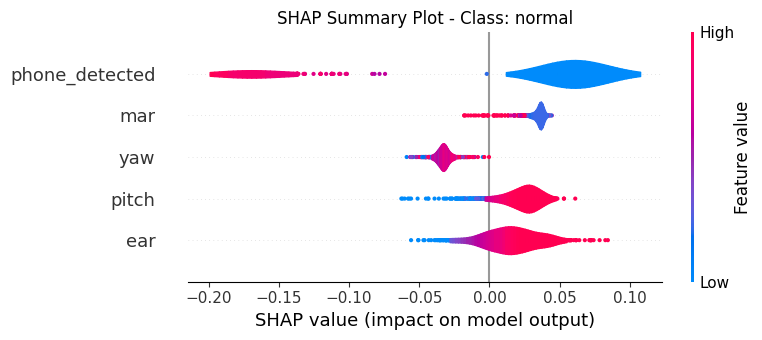

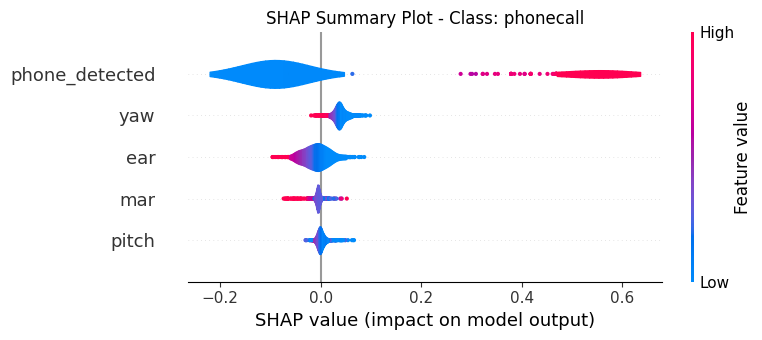

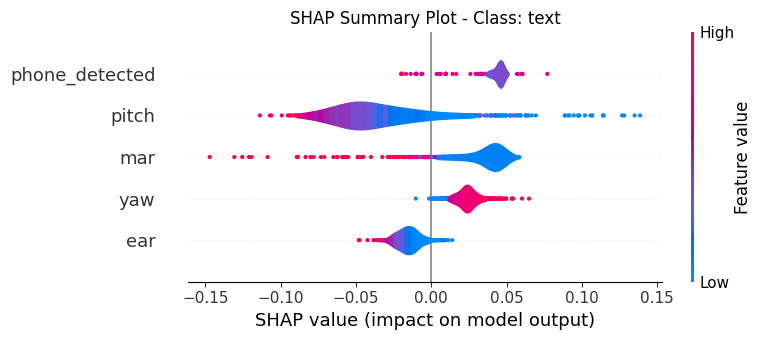

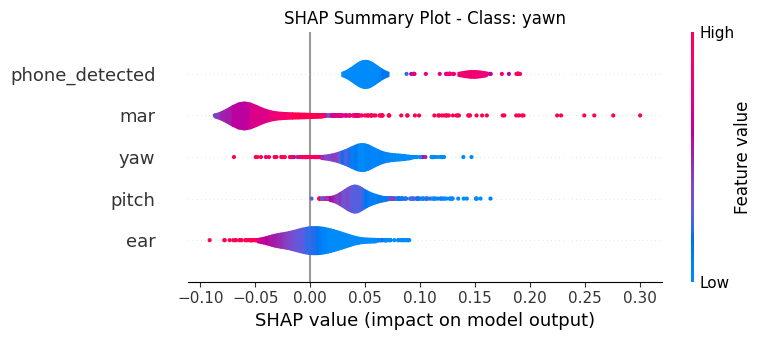

In [58]:
# 전체 데이터
for i in range(4):
    plt.figure()
    shap.summary_plot(
        shap_vals[:, :, i],
        X_test_mean_np,
        feature_names=cfg.features,
        plot_type="violin",
        show=False
    )
    plt.title(f"SHAP Summary Plot - Class: {cfg.labels[i]}")
    plt.tight_layout()
    plt.show()

Class name : normal, number of samples : 592


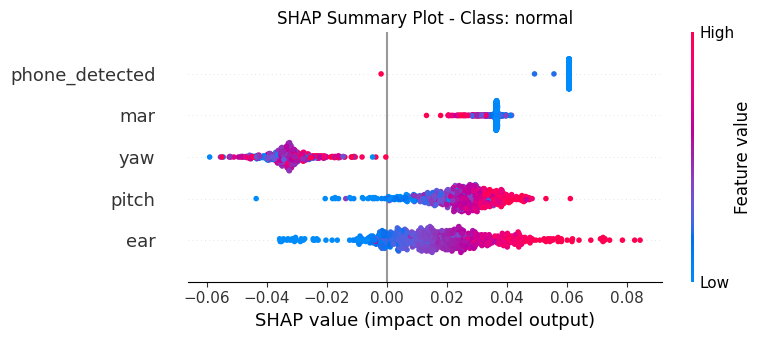

Class name : phonecall, number of samples : 237


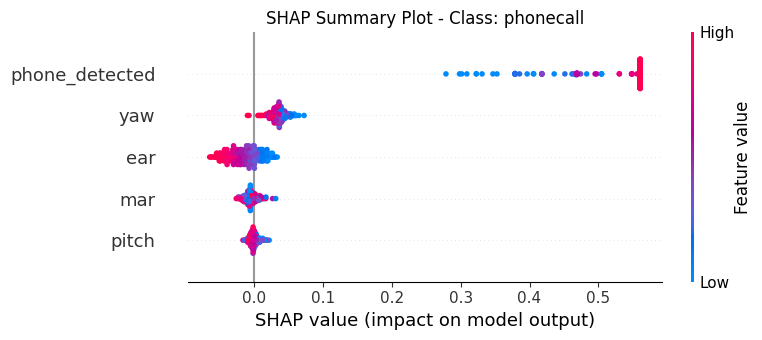

Class name : text, number of samples : 107


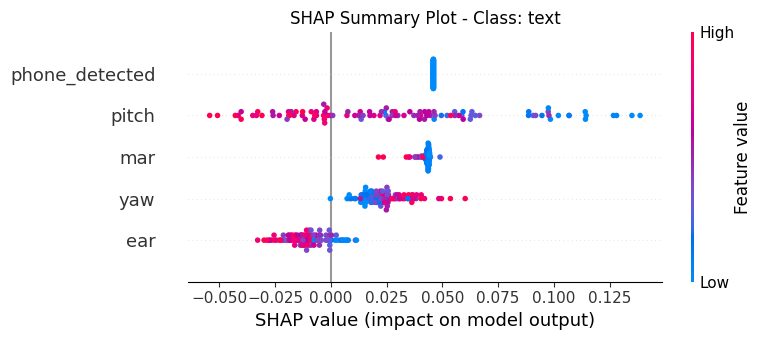

Class name : yawn, number of samples : 53


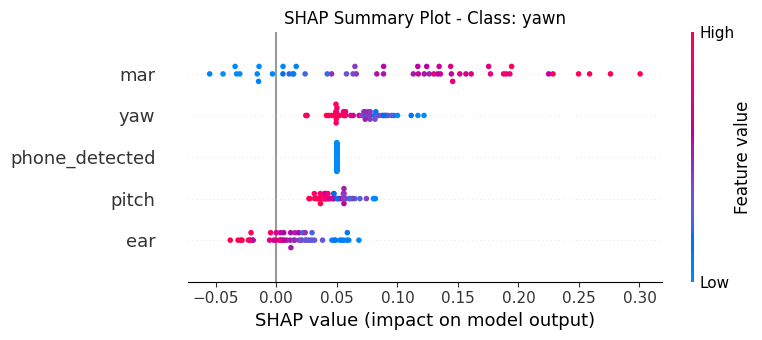

In [59]:
# 클래스별 데이터
for i in range(4):
    # 클래스 i에 해당하는 샘플 인덱스만 필터링
    idx = (all_test_labels == i)

    # 해당 클래스 샘플의 shap값과 입력 데이터 필터링
    shap_vals_i = shap_vals[idx, :, i]  # (샘플 수_i, 피처 수)
    X_test_i = X_test_mean_np[idx, :]   # (샘플 수_i, 피처 수)

    if shap_vals_i.shape[0] == 0:
        print(f"Class {cfg.labels[i]} has no samples in y_true, skipping plot.")
        continue

    print(f'Class name : {cfg.labels[i]}, number of samples : {shap_vals_i.shape[0]}')
    plt.figure()
    shap.summary_plot(
        shap_vals_i,
        X_test_i,
        feature_names=cfg.features,
        show=False
    )
    plt.title(f"SHAP Summary Plot - Class: {cfg.labels[i]}")
    plt.tight_layout()
    plt.show()

## 추가 eda

### SHAP 값 분포 요약 통계 구하기

'''
mean_abs_shap가 높을수록 summary plot의 상위에 나온다
'''

In [60]:
shap_vals.shape

(989, 5, 4)

In [61]:
shap_array = shap_vals
feature_names = cfg.features  # ['pitch', 'mar', 'phone_detected', 'ear', 'yaw']

In [62]:
summaries = {}  # 클래스별 요약 통계 저장용 딕셔너리

for i, label in enumerate(cfg.labels):
    idx = (all_test_labels == i) # 실제 클래스가 i인 샘플의 인덱스 추출

    # 해당 샘플이 하나도 없으면 건너뜀
    if idx.sum() == 0:
        print(f"Class {label} has no samples in y_true, skipping stats.")
        continue

    # 해당 클래스의 SHAP 값만 선택
    shap_df = pd.DataFrame(shap_array[idx, :, i], columns=cfg.features)  # (샘플 수_i, 피처 수)

    # 통계 요약 계산
    summaries[label] = pd.DataFrame({
        "mean_abs_shap": shap_df.abs().mean(),
        "std_shap": shap_df.std(),
        "max_shap": shap_df.max(),
        "min_shap": shap_df.min(),
        'sample_count' : len(shap_df)
    }).sort_values("mean_abs_shap", ascending=False)

### 변수 간 중요도 차이 수치 비교

In [63]:
for i in cfg.labels:
    df = summaries[i]
    df["rank_diff_from_top"] = df["mean_abs_shap"].iloc[0] - df['mean_abs_shap']
    summaries[i] = df

In [64]:
for i in cfg.labels:
    print(f"=== SHAP Summary for '{i}' class ===")
    print(summaries[i])

=== SHAP Summary for 'normal' class ===
                mean_abs_shap  std_shap  max_shap  min_shap  sample_count  \
phone_detected       0.060581  0.002623  0.060709 -0.001888           592   
mar                  0.035268  0.003488  0.041575  0.013230           592   
yaw                  0.032751  0.007123 -0.000314 -0.058985           592   
pitch                0.025567  0.012325  0.061140 -0.043501           592   
ear                  0.022144  0.020259  0.084378 -0.035693           592   

                rank_diff_from_top  
phone_detected            0.000000  
mar                       0.025313  
yaw                       0.027830  
pitch                     0.035014  
ear                       0.038437  
=== SHAP Summary for 'phonecall' class ===
                mean_abs_shap  std_shap  max_shap  min_shap  sample_count  \
phone_detected       0.532170  0.062755  0.560561  0.278608           237   
yaw                  0.035733  0.010160  0.072581 -0.009730           237   
e

### 상위 피쳐들의 feature value와 SHAP value 산점도

Text(0.5, 1.0, '첫 번째 feature 분포 비교')

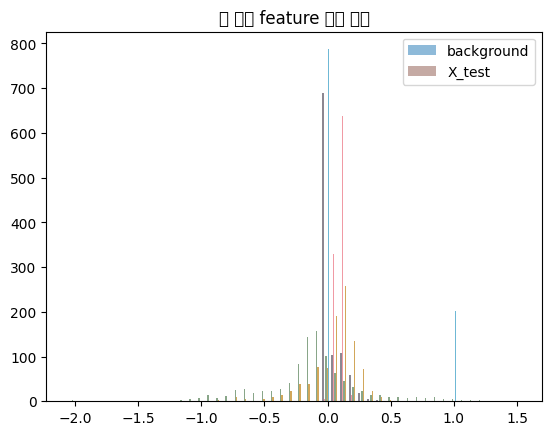

In [65]:
plt.hist(background[:, 0].cpu().numpy(), bins=50, alpha=0.5, label="background")
plt.hist(all_test_inputs[:, 0].cpu().numpy(), bins=50, alpha=0.5, label="X_test")
plt.legend(); plt.title("첫 번째 feature 분포 비교")

In [66]:
def plot_shap_feature_scatter(class_index):
    """
    특정 클래스 샘플만 필터링하여, mean_abs_shap 기준 상위 feature부터 순서대로
    각 feature value와 SHAP value의 관계를 산점도로 표현하고 mean_abs_shap 값 출력
    """
    label = cfg.labels[class_index]
    idx = (all_test_labels == class_index)

    if idx.sum() == 0:
        print(f"[{label}] 클래스에 해당하는 샘플이 없습니다. 시각화를 건너뜁니다.")
        return

    # 해당 클래스의 SHAP 값과 feature 값 필터링
    shap_vals = shap_array[idx, :, class_index]  # (샘플 수_i, 피처 수)
    X_vals = X_test_mean_np[idx, :]              # (샘플 수_i, 피처 수)

    # DataFrame 변환
    shap_df = pd.DataFrame(shap_vals, columns=cfg.features)
    X_df = pd.DataFrame(X_vals, columns=cfg.features)

    # summary에서 해당 클래스의 상위 feature 순서 가져오기
    summary = summaries[label]
    top_features = summary.index.tolist()  # mean_abs_shap 기준 정렬됨

    # 피처별 산점도
    for feat in top_features:
        mean_abs_val = summary.loc[feat, "mean_abs_shap"]
        print(f"[{label}] Feature: {feat}, mean_abs_shap = {mean_abs_val:.2f}, number of sample = {len(shap_df)}")

        plt.figure(figsize=(5, 4))
        sns.scatterplot(x=X_df[feat], y=shap_df[feat], alpha=0.7)
        plt.title(f"[{label}] {feat} vs SHAP Value\n(mean_abs_shap={mean_abs_val:.2f})")
        plt.xlabel("Feature Value")
        plt.ylabel("SHAP Value")
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)
        plt.tight_layout()
        plt.show()

[normal] Feature: phone_detected, mean_abs_shap = 0.06, number of sample = 592


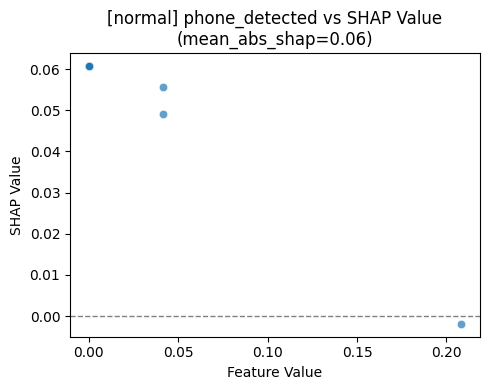

[normal] Feature: mar, mean_abs_shap = 0.04, number of sample = 592


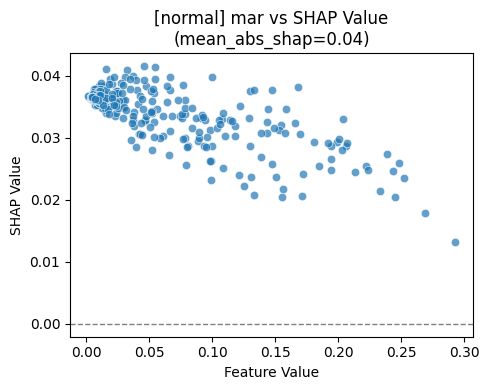

[normal] Feature: yaw, mean_abs_shap = 0.03, number of sample = 592


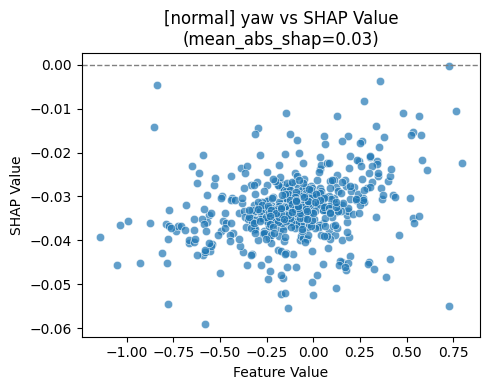

[normal] Feature: pitch, mean_abs_shap = 0.03, number of sample = 592


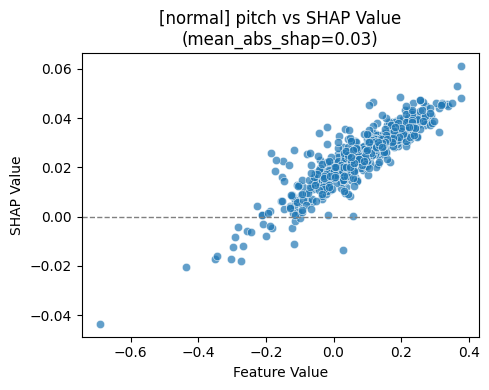

[normal] Feature: ear, mean_abs_shap = 0.02, number of sample = 592


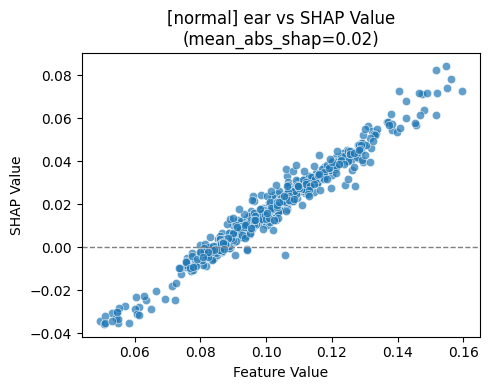

In [67]:
plot_shap_feature_scatter(class_index=0)

[phonecall] Feature: phone_detected, mean_abs_shap = 0.53, number of sample = 237


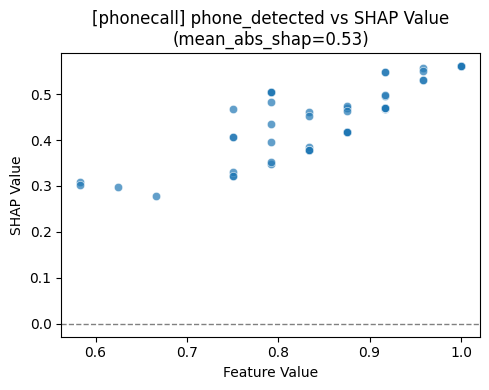

[phonecall] Feature: yaw, mean_abs_shap = 0.04, number of sample = 237


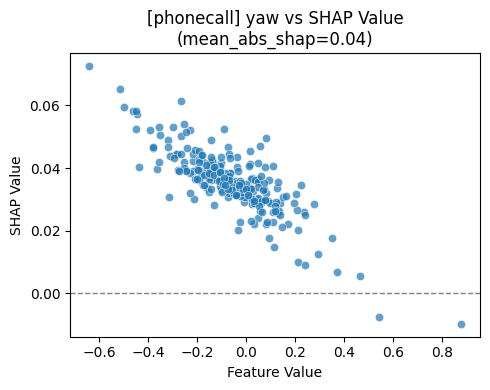

[phonecall] Feature: ear, mean_abs_shap = 0.02, number of sample = 237


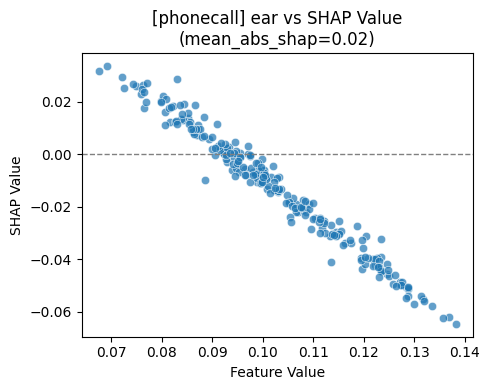

[phonecall] Feature: mar, mean_abs_shap = 0.01, number of sample = 237


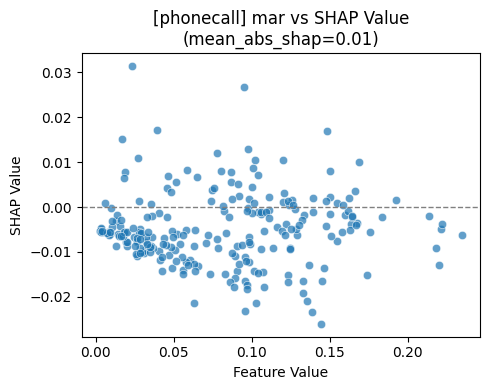

[phonecall] Feature: pitch, mean_abs_shap = 0.00, number of sample = 237


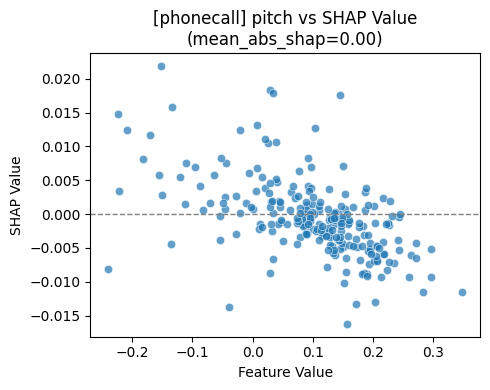

In [68]:
plot_shap_feature_scatter(class_index=1)

[text] Feature: phone_detected, mean_abs_shap = 0.05, number of sample = 107


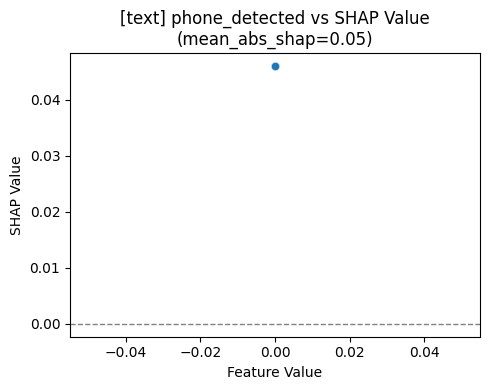

[text] Feature: pitch, mean_abs_shap = 0.04, number of sample = 107


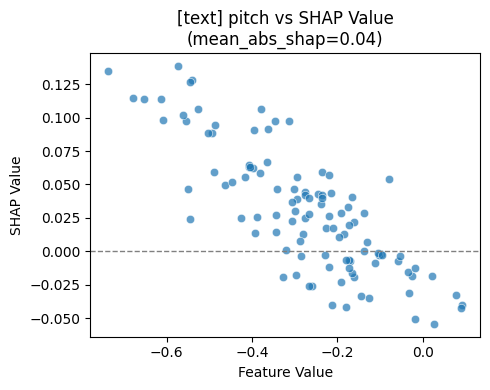

[text] Feature: mar, mean_abs_shap = 0.04, number of sample = 107


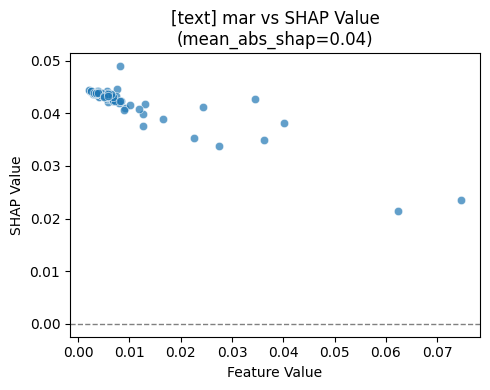

[text] Feature: yaw, mean_abs_shap = 0.02, number of sample = 107


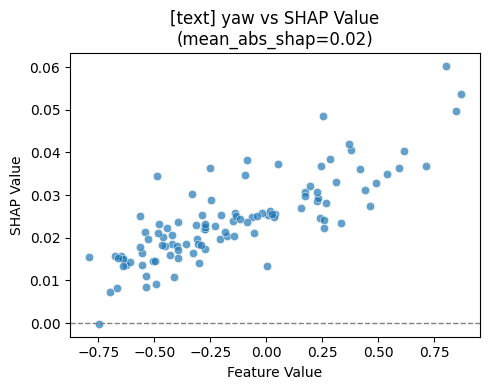

[text] Feature: ear, mean_abs_shap = 0.01, number of sample = 107


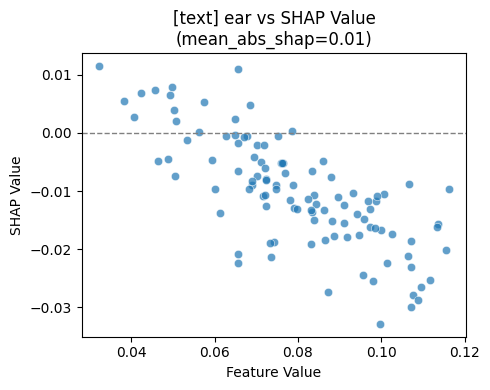

In [69]:
plot_shap_feature_scatter(class_index=2)

[yawn] Feature: mar, mean_abs_shap = 0.11, number of sample = 53


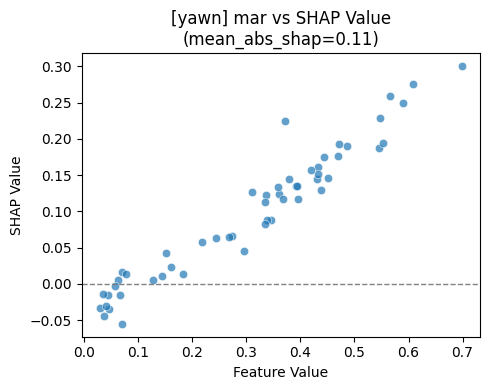

[yawn] Feature: yaw, mean_abs_shap = 0.07, number of sample = 53


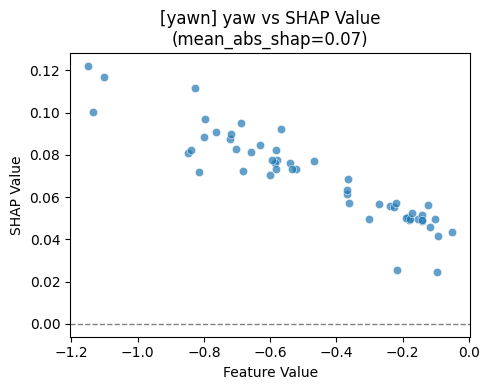

[yawn] Feature: phone_detected, mean_abs_shap = 0.05, number of sample = 53


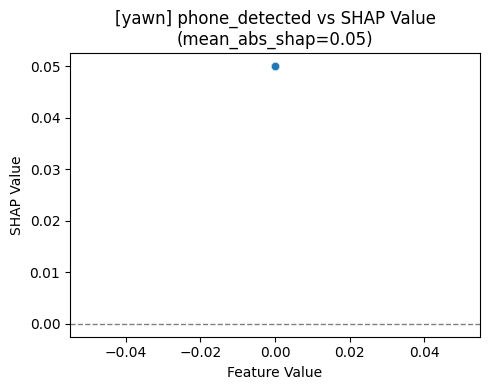

[yawn] Feature: pitch, mean_abs_shap = 0.05, number of sample = 53


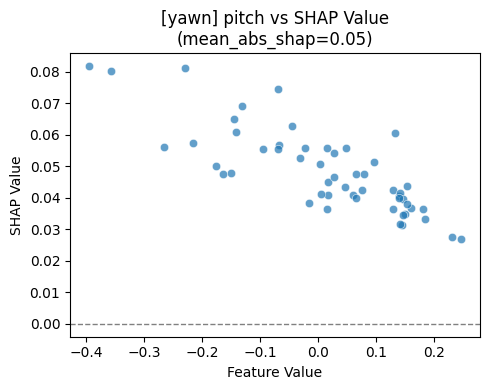

[yawn] Feature: ear, mean_abs_shap = 0.02, number of sample = 53


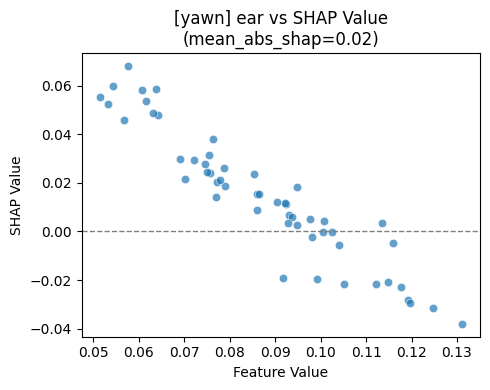

In [70]:
plot_shap_feature_scatter(class_index=3)

'''
X축: yaw의 feature 값

Y축: yaw가 text 클래스에 대해 갖는 SHAP 값

즉, 각 샘플의 yaw 값이 text 클래스 예측에 얼마나 영향을 줬는지 보여줌

shap값이 0보다 크거나 작으면 해당 클래스일 확률을 높이거나 낮추는데 0이면 아무런 영향없음

해당 클래스를 설명하는데 유용한 피쳐라고 할 수 있는 근거들

1. SHAP 값의 범위가 넓은가? -> 넓을수록 영향력이 크다

2. 산점도의 패턴이 존재하는가? -> shap값 변화의 패턴이 존재

3. 극단적인 피쳐 값에서 shap값도 극단적인가? -> 특정 값 구간에서 shap값 변화가 크면 영향이 크다는 의미

4. shap값의 분산이 큰가? -> 비슷한 피쳐 값에서 shap값 변화가 크다면 그 피쳐가 다양한 방식으로 영향을 미친다는 것

5. 데이터 밀도가 높을 때 shap가 일관적인가? -> 샘플수가 많은 영역에서 값의 방향이 동일하다면 신뢰도가 높다

 중요도가 높고 경향성이 불명확한 피쳐보다 중요도는 더 낮지만 경향성이 뚜렷한 피쳐를 더 중요한 것으로 간주해도 타당하다
'''